In [4]:
import cv2
import numpy as np
from matplotlib import pyplot as plt  

In [253]:
# 自动识别出最接近量表的图片并分割
def cutPicOld(path):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    # plt.imshow(img,cmap = 'gray')
    # plt.show()
    
    # 1 水表图形分割
    aim = img[:1000, 700:1000]
    # aim = img
    print("分割后图片为：")
    plt.imshow(aim,cmap = 'gray')
    plt.show()
    return aim

In [259]:
def preProcess(aim, contType = "sim", Bi_LB = 173):
    # 2. 预处理
    # 2.1 直方图均衡化提高度对比度

    # 查看原始直方图
    # plt.hist(aim.ravel(),256,[0,256]);  
    # plt.show() 

    # 先平滑后均衡
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(aim,-1,kernel)
    # dst = cv2.GaussianBlur(dst,(5,5),0)

    equ = cv2.equalizeHist(dst)  
    '''
    print("平滑后图片为：")
    plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
    plt.xticks([]), plt.yticks([])
    plt.subplot(122),plt.imshow(equ,cmap = 'gray'),plt.title('Averaging')
    plt.xticks([]), plt.yticks([])
    plt.show()
    '''

    # 查看平滑后直方图
    # plt.hist(equ.ravel(),256,[0,256]);  
    # plt.show() 
    
    # 2.2 闭运算：先膨胀后腐蚀, 填充前景物体中的小洞
    closing = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel)
    '''
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(closing, cmap = 'gray')  
    plt.title('Closing Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    # 2.3 图像去噪
    dst_de = cv2.fastNlMeansDenoising(closing, None, 50, 7, 21)
    '''
    print("去除噪点后图片为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(dst_de, cmap = 'gray')  
    plt.title('Denoise Image'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    '''
    
    # 2.4 二值化
    ret,thresh = cv2.threshold(dst_de,Bi_LB,255,0)
    '''
    print("二值化后图片为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(thresh, cmap = 'gray')  
    plt.title('Thresh Image'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    '''
    
    # 2.5 Canny 边缘检测
    edges = cv2.Canny(thresh,50,150) 
    '''
    print("边缘检测结果为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
    plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
    plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    
    # 2.6 轮廓提取
    ret,thresh = cv2.threshold(dst_de,Bi_LB,255,0)
    
    if contType == "sim":
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    else:
        contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_NONE)
        
    '''
    print("水表轮廓为：")
    plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
    plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制
    # result[:, 95:105] = (0,0,255)
    # result[:, 125:135] = (0,0,255)
    result[:, 145:155] = (0,0,255)

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show()  
    '''
    return equ, contour

In [260]:
# 基于轮廓形状找出对称连续线段
def findContourByShape(leftContour, rightContour):
    # ============== 找出左右连续线段 ======================
    leftPos = 0
    leftSize = len(leftContour)
    
    rightPos = 0
    rightSize = len(rightContour)
    
    # 1 扫描左侧轮廓中的连续线段
    leftBlock = []
    for w in range(0, 200):
        # 1.1 基于点的高度进行分块
        w2 = w * 5
        block = []
        while (leftPos < leftSize and leftContour[leftPos][0, 1] < w2 + 5):
            if leftContour[leftPos][0, 1] >= w2:
                block.append(leftContour[leftPos])
            leftPos += 1
            
        # 1.2 检查同一高度block中是否存在连续线段
        conNum = 0
        maxConLen = 0
        pre = 0
        block.sort(key=takeFirst)
        for arr in block:
            if (arr[0, 0] - pre) < 5:
                conNum += 1
                maxConLen = max(maxConLen, conNum)
            else:
                conNum = 0
            pre = arr[0, 0]
            
        # 1.3 保存连续线段
        if maxConLen > 15:
        # if len(block) > 4:
            leftBlock.append(block)
        if (leftPos >= leftSize):
            break
    
    # 2 扫描右侧轮廓中的连续线段
    rightBlock = []
    for w in range(0, 200):
        # 2.1 基于点的高度进行分块
        w2 = w * 5
        block = []
        while (rightPos < rightSize and rightContour[rightPos][0, 1] < w2 + 5):
            if rightContour[rightPos][0, 1] >= w2:
                block.append(rightContour[rightPos])
            rightPos += 1
            
        # 2.2 检查同一高度block中是否存在连续线段
        conNum = 0
        maxConLen = 0
        pre = 0
        block.sort(key=takeFirst)
        for arr in block:
            if (arr[0, 0] - pre) < 5:
                conNum += 1
                maxConLen = max(maxConLen, conNum)
            else:
                conNum = 0
            pre = arr[0, 0]
            
        # 2.3 保存连续线段    
        if maxConLen > 15:
            rightBlock.append(block)
        if (rightPos >= rightSize):
            break
     
    # 返回图块中对称的连续线段数
    print(len(leftBlock), len(rightBlock))
    symNum = min(len(leftBlock), len(rightBlock))
    
    return symNum

In [ ]:
# 排序设定函数
def takeFirst(elem):
    return elem[0, 0]

def takeSecond(elem):
    return elem[0, 1]

# 自动识别出最接近量表的图片并分割
def cutPic(path):
    # 0 读入原始照片
    img = cv2.imread(path,0)
    
    # 0.2 照片尺寸
    high = len(img)
    wid = img[0].size
    
    # 1 水表图形分割
    windowSize = 40
    print("预设的滑动窗口尺寸为：", windowSize)
    
    windowNum = int((wid - 300) / windowSize)
    print("图片共分割为",windowNum,"个待扫描图块")
    
    maxSym = 0
    maxWindow = 0
    print("开始对图片进行自动滑动窗口扫描：")
    
    for i in range(0, windowNum):
        bias = i * windowSize
        
        aim = img[0:1000, bias:bias+300]
        print("待扫描图块范围为：[0:1000, ",bias,":",bias+300,"]")
        
        # 1 提取轮廓
        equ, contour = preProcess(aim, "none")
        
        # ================= 2 计算当前图例中最大轮廓面积 =======================
        maxA = 0
        maxIn = 0
        for j in range(0, len(contour)):
            arr = contour[j]
            area = cv2.contourArea(arr)
            if area > maxA:
                maxA = area
                maxIn = j
                
        # print("当前图块的最大轮廓面积为：", maxA)
        # if maxA < 150000:
            # print("轮廓面积过小，跳过当前窗口。")
            # continue
        
         # ================= 3 划分左右轮廓 =================
        midWid = wid / 2
        
        leftContour = []
        rightContour = []
        
        # 开始划分
        for arr in contour[maxIn]:
            if arr[0, 0] <= 150:
                leftContour.append(arr)
            else:
                rightContour.append(arr)
        
        # ================= 4 按照高度排序 =================
        leftContour.sort(key=takeSecond)
        rightContour.sort(key=takeSecond)
        
        leftPos = 0
        leftSize = len(leftContour)
    
        rightPos = 0
        rightSize = len(rightContour)
        
        # ================= 5 计算对称点数量 =================
        symNum = 0
        
        # 方法1：基于形状进行计算
        # 用时最少，准确率一般
        # symNum = findContourByShape(leftContour, rightContour)
        
        # 方法2：穷举法
        # 用时最多，准确率最高
        for a1 in range(0, leftSize):
            for a2 in range(0, rightSize):
                 if abs(leftContour[a1][0, 1] - rightContour[a2][0, 1]) < 3:
                        if abs(abs(leftContour[a1][0, 0] - 150) - abs(rightContour[a2][0, 0] - 150)) < 30:
                            symNum += 1
    
        # 方法3：顺序法
        # 用时中等，准确率较好
        ''' 
        leftPos = 0
        rightPos = 0
        while leftPos < leftSize and rightPos < rightSize :
            if abs(leftContour[leftPos][0, 1] - rightContour[rightPos][0, 1]) < 10:
                if abs(leftContour[leftPos][0, 0] - 150) < 20 and abs(rightContour[rightPos][0, 0] - 150) < 20:
                    print(leftContour[leftPos], ":", rightContour[rightPos])
                    symNum += 1   
            if (leftContour[leftPos][0, 1] < rightContour[rightPos][0, 1]):
                leftPos += 1
            else:
                rightPos += 1
        '''
        # print("该图块对称点个数为：", symNum)

        if symNum > maxSym:
            maxSym = symNum
            maxWindow = i
            # print(maxSym, symNum, i)
    
    print("自动识别得到的与水表最近似的图块为：")
    
    bias = maxWindow * windowSize
    aim = img[:1000, bias:bias+300]
    equ, contour = preProcess(aim)
    
    plt.subplot(121),plt.imshow(aim, cmap = 'gray')  
    plt.title('Cut Image'), plt.xticks([]), plt.yticks([])
    
    color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制

    plt.subplot(122),plt.imshow(result)  
    plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
    plt.show() 

    return aim

In [320]:
# ============== 提取轮廓组中最大面积轮廓 ==============
def maxContourArea(contour):
    maxArea = 0
    maxA = 0
    for j in range(0, len(contour)):
        arr = contour[j]
        area = cv2.contourArea(arr)
        if area > maxArea:
            maxArea = area
            maxA = j
    return maxA

# ============== 找出最低水位线位置 ==============
def minWaterLine(maxContour, Height_0):
    rub = 0
    minH = 0
    minIn = 0
    for i in range(0, len(maxContour)):
        if maxContour[i][0, 1] <= Height_0:
            rub = i
            if  maxContour[i][0, 1] > minH:
                minH = maxContour[i][0, 1]
                minIn = i
    return minIn
    
# ============== 找出水位线位置 ==============
def maxWaterLine(maxContour, Height_0, minH):
    rub = 0
    maxH = Height_0
    minIn = 0
    for i in range(0, len(maxContour)):
        if maxContour[i][0, 1] <= Height_0 and maxContour[i][0, 1] > minH:
            rub = i
            if  maxContour[i][0, 1] < maxH:
                maxH = maxContour[i][0, 1]
                minIn = i
    return minIn

# ============== 计算平均像素值 ==============
def countAverPixel(equ, leftBound, rightBound, height):
    num = 0
    P_total = 0
    
    for i in range(leftBound, rightBound):
        P_total += equ[height, i]
        num += 1
    
    return P_total / num

# ============== 计算水位线 ==============

def getWaterLine(equ, contour, aim):
    
    # ============================ 3.1 找出量表轮廓位置: max s.t. contour[0].size ==============
    
    # 方法 1： 基于轮廓点数找出量表轮廓 ==============
    '''
    maxA = 0
    maxS = contour[0].size

    for i in range(0, len(contour)):
        if (contour[i].size > maxS):
            maxA = i
            maxS = contour[i].size 
    print(maxA, maxS)  
    '''
    
    # 方法 2： 基于轮廓面积找出量表轮廓 ==============
    maxA = maxContourArea(contour) # 最大面积轮廓
            
    # print(maxA, maxArea)
    
    # ============================ 3.2 分割出量表区域 [st : en] ============================
    st = 0
    while (contour[maxA][st][0, 1] < len(equ) / 2):
        st += 1;
    
    en = st + 1
    while (contour[maxA][en][0, 1] > len(equ) / 2):
        en += 1; 
    
    # print(st, en)   # 量表区域：[st : en]
    
    # 查看量表区域
    ''' 
    equ_color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    result = cv2.drawContours(equ_color, [contour[maxA][st:en]], -1, (0,255,0), 2) #轮廓用绿色绘制
    plt.imshow(result)  
    plt.title('Water Line'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    '''
    
    # ============================ 3.3 找出最低端零刻度 ============================
    Index_0 = 0
    Height_0 = 0  # 零刻度高度
    
    for i in range(st, en):
        if (contour[maxA][i][0, 1] > Height_0):
            Index_0 = i
            Height_0 = contour[maxA][i][0, 1]

    # print(contour[maxA][Index_0]) # 零刻度位置

    # ============================ 3.4 记录零刻度边界 ============================
    arr_zero = []

    left_0 = contour[maxA][Index_0][0, 0]
    right_0 = left_0
    
    # ========== 找出零刻度左右边界 ==========
    for i in range(st, en):
        if (abs(contour[maxA][i][0, 1] - Height_0) < 20):
            arr_zero.append(contour[maxA][i])
            if (contour[maxA][i][0, 0] < left_0):
                left_0 = contour[maxA][i][0, 0]
            if (contour[maxA][i][0, 0] > right_0):
                right_0 = contour[maxA][i][0, 0]    
        
    print("零刻度位置为:[",Height_0,",", left_0,":",right_0,"]") # 零刻度坐标
     
    # ========== 绘制零刻度图像 ==========
    zero_color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    zero_color[Height_0 - 2 : Height_0 + 2, left_0:right_0] = (0,255,0)
    # zero_img = equ[Height_0-10:Height_0+10, left_0-20:right_0+20]
    # zero_color[Height_0 - 22 : Height_0 -18, left_0:right_0] = (0,255,0)
    
    plt.imshow(zero_color[500:, :])  
    plt.title(' Zero Pos'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    
    # ============================ 3.5 记录刻度位置数组 ============================
    
    # 基于零刻度位置提取水表图块
    zero2scale = 20
    waterTable = aim[:1000, left_0 - zero2scale:right_0 + zero2scale]
    
    equW, contourW = preProcess(waterTable)
    
    # 找到水表轮廓
    maxAW = maxContourArea(contourW)
            
    print("提取得到的水表轮廓为：")
    # print(contourW[maxAW])
    wt_color = cv2.cvtColor(equW, cv2.COLOR_GRAY2BGR)
    wt_result = cv2.drawContours(wt_color, [contourW[maxAW]], -1, (0,255,0), 2) #轮廓用绿色绘制
    
    plt.imshow(wt_result)  
    plt.title(' Water Table'), plt.xticks([]), plt.yticks([])  
    plt.show()
    
    arr_peak = [] # 刻度数组
    
    # 手动设置坐标边界
    right_bound = min(right_0 + zero2scale, 300) # 刻度右边界
    left_bound = max(left_0 - zero2scale, 0)   # 刻度左边界
    
    pre = 0
    for i in range(1, len(contourW[maxAW])):
        i_x = contourW[maxAW][i][0, 0]
        
        # 自动计算水表边境
        '''
        if (i_x > right_bound and i_x < right_0 + 10):
            right_bound = i_x
            
        if (i_x < left_bound and i_x > left_0 - 10):
            left_bound = i_x
        '''
              
        # 判断是否为刻度 ==============
        if i_x >= left_bound and i_x <= left_bound:
            if contourW[maxAW][i][0, 1] - pre > 15:
                arr_peak.append(contourW[maxAW][i][0])
                pre = contourW[maxAW][i][0, 1]
        
    # print(arr_peak) # 刻度坐标 
        
    print("刻度边界为: [",left_bound, ",", right_bound, "]")  
    
    # 绘制得到的刻度
    
    equ_color = cv2.cvtColor(equW, cv2.COLOR_GRAY2BGR)
    for arr in arr_peak:
        equ_color[arr[1] - 5 : arr[1] + 5, arr[0] - 5 : arr[0] + 5] = (0,255,0)
    
    # '''
    print("作为参考的刻度为：")
    plt.imshow(equ_color)  
    plt.title('Water Meter Scale'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    # '''
    # ============================ 3.6 计算单位刻度长度 ============================
    div = 0
    num = 0
    pre = arr_peak[0][1]
    for i in range(1, len(arr_peak)):
        # print(pre, arr_peak[i][1])
        hDis = abs(arr_peak[i][1] - pre)
        
        if hDis > 30:
            break
            
        if  hDis > 8:
            div += (arr_peak[i][1] - pre)
            num += 1
            pre = arr_peak[i][1]
        

    lengthPer = div / num # 单位刻度
    print("单位刻度的图中平均长度为：", lengthPer)
    
    # ============================ 3.7 获得轮廓转折点 ============================
    
    # 左水位线范围
    leftLvBound = max(left_0 - 65, 0)
    rightLvBound = min(left_0 - 5, 300)
    
    print("左水位线边界为: [",leftLvBound, ",", rightLvBound, "]")  
    
     # 基于刻度边界取出水位线区域
    leftLine = aim[:1000, leftLvBound : rightLvBound]
    
    # '''
    # 绘制左水位线轮廓
    plt.imshow(leftLine, cmap = 'gray')  
    plt.title('leftLine'), plt.xticks([]), plt.yticks([])  
    plt.show() 
   #  '''
    
    # 测试最小水位线
    equ_left, contour_left = preProcess(leftLine)
    
    # 提取左水位线
    maxAL = maxContourArea(contour_left)
    
    # 找出水位线位置 ==============
    minIn = minWaterLine(contour_left[maxAL], Height_0)
    minH = contour_left[maxAL][minIn][0, 1]
    
    # ============== 3.8 记录像素最小下限 ==============
    lv_LB = countAverPixel(equ, leftLvBound, rightLvBound, minH - 10)
    lv_UB = countAverPixel(equ, leftLvBound, rightLvBound, Height_0)

    print("像素值的上下限为： [", lv_UB, ":", lv_LB, "]")
    
    # ============== 3.9 迭代二值化像素界限，找到最低水位线 ==============
    
    conSize = len(contour_left[maxAL])
    minTH = lv_LB
    lv = lv_LB
    while (conSize > 50 and lv >= lv_UB and lv <= lv_LB):
        equ_tem, contour_tem = preProcess(leftLine, 'sim', lv + 5)
        
        # 找出最大轮廓
        maxAtem = maxContourArea(contour_tem)
        conSize = len(contour_tem[maxAtem])
        
        # 计算最低水位
        minInTem = maxWaterLine(contour_tem[maxAtem], Height_0, minH)
        minHtem = contour_tem[maxAtem][minInTem][0, 1]

        if minHtem <= Height_0 and minHtem > minH:
            minH = minHtem
            minTH = lv
            # area = cv2.contourArea(contour_tem[maxAtem])
            print("minH = ", minH, ", ", "size = ", len(contour_tem[maxAtem]))
            
            '''
            # 查看当前二值化界限下水位线识别结果
            print('Water Line in ', lv, ' is ', minH)
            
            color_tem = cv2.cvtColor(equ_tem, cv2.COLOR_GRAY2BGR)
            result_tem = cv2.drawContours(color_tem, [contour_tem[maxAtem]], -1, (0,255,0), 2) #轮廓用绿色绘制
            plt.imshow(result_tem)  
            plt.title('Water Line'), plt.xticks([]), plt.yticks([])  
            plt.show() 
            '''
        lv -= 10
        
        # 底线设置
        if (lv < lv_UB):
            lv = lv_UB
            
            equ_tem, contour_tem = preProcess(leftLine, 'sim', lv_UB + 5)
        
            # 找出最大轮廓
            maxAtem = maxContourArea(contour_tem)
            conSize = len(contour_tem[maxAtem])
        
            # 计算最低水位
            minInTem = maxWaterLine(contour_tem[maxAtem], Height_0, minH)
            minHtem = contour_tem[maxAtem][minInTem][0, 1]
            
            if minHtem <= Height_0 and minHtem > minH:
                minH = minHtem
                minTH = lv
            break

    '''
    leftLine_color = cv2.cvtColor(leftLine, cv2.COLOR_GRAY2BGR)
    result_left = cv2.drawContours(leftLine_color, [contour_left[maxAL]], -1, (0,255,0), 2) #轮廓用绿色绘制
    
    plt.imshow(result_left)  
    plt.title('Water Line'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    
    
    print("水位线位置为：")
    print(contour_left[maxAL][minIn])
    '''
    # print(waterLine)
    
    print("水位线位置为：")
    waterLine = minH
    print(waterLine)
    
    equ_color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
    equ_color[waterLine - 3 : waterLine + 3, :] = (0,255,0)
        
    plt.imshow(equ_color)  
    plt.title('Water Line'), plt.xticks([]), plt.yticks([])  
    plt.show() 
    
    # print(waterLine)

    # for i in range(rub, len(contour[maxA]) - 1):
    #     if (contour[maxA][i][0, 1] < waterLine):
    #         # print(contour[maxA][i])
    #         waterLine = contour[maxA][i][0, 1]   
    # print(waterLine)

    # 3.8 计算当前水位
    # print("水位线坐标为：[",waterLine, ",", left_bound+700, "] 到 [",waterLine, ",", right_bound+700, "]")
    print("当前水位与零刻度线相差的刻度数为：", (Height_0 - waterLine) / lengthPer)
    print("当前水位为：", (Height_0 - waterLine) / (lengthPer * 5) * 10 - 0.5, "mm")

In [314]:
def run():
    path = input("请输入待识别图像路径：")
    # path = "sample8.jpg"
    aim = cutPic(path)
    # print("水位轮廓为：")
    equ, contour = preProcess(aim)
    getWaterLine(equ, contour, aim)

请输入待识别图像路径：sample0800.jpg
预设的滑动窗口尺寸为： 40
图片共分割为 40 个带扫描图块
开始对图片进行自动滑动窗口扫描：
待扫描图块范围为：[0:1000,  0 : 300 ]
待扫描图块范围为：[0:1000,  40 : 340 ]
待扫描图块范围为：[0:1000,  80 : 380 ]
待扫描图块范围为：[0:1000,  120 : 420 ]
待扫描图块范围为：[0:1000,  160 : 460 ]
待扫描图块范围为：[0:1000,  200 : 500 ]
待扫描图块范围为：[0:1000,  240 : 540 ]
待扫描图块范围为：[0:1000,  280 : 580 ]
待扫描图块范围为：[0:1000,  320 : 620 ]
待扫描图块范围为：[0:1000,  360 : 660 ]
待扫描图块范围为：[0:1000,  400 : 700 ]
待扫描图块范围为：[0:1000,  440 : 740 ]
待扫描图块范围为：[0:1000,  480 : 780 ]
待扫描图块范围为：[0:1000,  520 : 820 ]
待扫描图块范围为：[0:1000,  560 : 860 ]
待扫描图块范围为：[0:1000,  600 : 900 ]
待扫描图块范围为：[0:1000,  640 : 940 ]
待扫描图块范围为：[0:1000,  680 : 980 ]
待扫描图块范围为：[0:1000,  720 : 1020 ]
待扫描图块范围为：[0:1000,  760 : 1060 ]
待扫描图块范围为：[0:1000,  800 : 1100 ]
待扫描图块范围为：[0:1000,  840 : 1140 ]
待扫描图块范围为：[0:1000,  880 : 1180 ]
待扫描图块范围为：[0:1000,  920 : 1220 ]
待扫描图块范围为：[0:1000,  960 : 1260 ]
待扫描图块范围为：[0:1000,  1000 : 1300 ]
待扫描图块范围为：[0:1000,  1040 : 1340 ]
待扫描图块范围为：[0:1000,  1080 : 1380 ]
待扫描图块范围为：[0:1000,  1120 : 1420 ]
待扫描图块范围为：[0:100

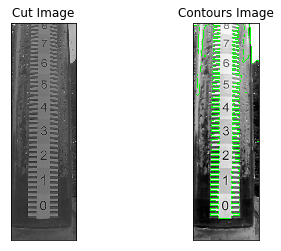

零刻度位置为:[ 900 , 78 : 212 ]


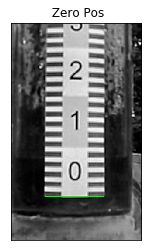

提取得到的水表轮廓为：


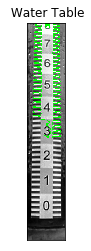

刻度边界为: [ 58 , 232 ]
作为参考的刻度为：


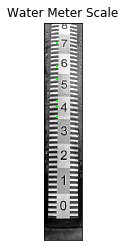

ZeroDivisionError: division by zero

In [322]:
# path = "sample8.jpg" sample3790.jpg sample1070.jpg sample0800.jpg
run()

In [271]:

# path = "sample1070.jpg"
# aim = cutPic(path)

# kernel = np.ones((5,5),np.float32)/25
# dst = cv2.filter2D(aim,-1,kernel)
# # dst = cv2.GaussianBlur(dst,(5,5),0)

# equ = cv2.equalizeHist(dst)  

# print("平滑后图片为：")
# plt.subplot(121),plt.imshow(aim,cmap = 'gray'),plt.title('Original')
# plt.xticks([]), plt.yticks([])
# plt.subplot(122),plt.imshow(equ,cmap = 'gray'),plt.title('Averaging')
# plt.xticks([]), plt.yticks([])
# plt.show()

# # 2.2 闭运算：先膨胀后腐蚀, 填充前景物体中的小洞
# closing = cv2.morphologyEx(equ, cv2.MORPH_CLOSE, kernel)

# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(closing, cmap = 'gray')  
# plt.title('Closing Image'), plt.xticks([]), plt.yticks([])  
# plt.show() 

# # 2.3 图像去噪
# dst_de = cv2.fastNlMeansDenoising(closing, None, 50, 7, 21)

# print("去除噪点后图片为：")
# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(dst_de, cmap = 'gray')  
# plt.title('Denoise Image'), plt.xticks([]), plt.yticks([])  
# plt.show() 

#  # 2.4 二值化
    
# # dst_gamma = dst_de/255.0     
# # # 伽马变换
# # gamma = 0.4
# # dst_gamma = np.power(dst_gamma, gamma) * 255.0
# # dst_gamma = dst_gamma.astype(np.uz

# ret,thresh = cv2.threshold(dst_de,173,255,0)

# print("二值化后图片为：")
# plt.subplot(121),plt.imshow(dst_de, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(thresh, cmap = 'gray')  
# plt.title('Thresh Image'), plt.xticks([]), plt.yticks([])  
# plt.show() 

# # 2.5 Canny 边缘检测
# edges = cv2.Canny(thresh,50,150) 

# print("边缘检测结果为：")
# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  
# plt.subplot(122),plt.imshow(edges, cmap = 'gray')  
# plt.title('Edge Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

# # 2.6 轮廓提取
# ret,thresh = cv2.threshold(dst_de,173,255,0)

# contour, hierarchy = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# # print(contour)

# print("水表轮廓为：")
# plt.subplot(121),plt.imshow(equ, cmap = 'gray')  
# plt.title('Original Image'), plt.xticks([]), plt.yticks([])  

# color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
# result = cv2.drawContours(color, contour, -1, (0,255,0), 2) #轮廓用绿色绘制
# # result[:, 95:105] = (0,0,255)
# # result[:, 125:135] = (0,0,255)
# # result[:, 145:155] = (0,0,255)

# plt.subplot(122),plt.imshow(result)  
# plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

# equ_50, contour_50 = preProcess(aim,'sim',50)

# color = cv2.cvtColor(equ, cv2.COLOR_GRAY2BGR)
# result = cv2.drawContours(color, [contour_50[11]], -1, (0,255,0), 2) #轮廓用绿色绘制

# plt.imshow(result)  
# plt.title('Contours Image'), plt.xticks([]), plt.yticks([])  
# plt.show()  

# getWaterLine(equ, contour, aim)